In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima

/tmp/ipykernel_9959/290259180.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("https://olinda.bcb.gov.br/olinda/servico/SPI/versao/v1/odata/PixLiquidadosAtual?$top=5000&$orderby=Data%20asc&$format=text/csv", decimal=',')
pix = df.copy()
pix.columns = ['Date', 'Quantity', 'Total', 'Mean']
pix = pix.set_index(pd.to_datetime(pix['Date'])).drop('Date', axis=1)

In [149]:
column = 'Quantity'

data = pix[[column]].copy()
data[column] = data[column]/1e6

data = data.resample('1D').sum().ffill()

y_hist = data['2023-03-01':'2024-02-29']
y_futr = data['2024-03-01':'2024-04-27']

y_diff = y_hist.diff().dropna()


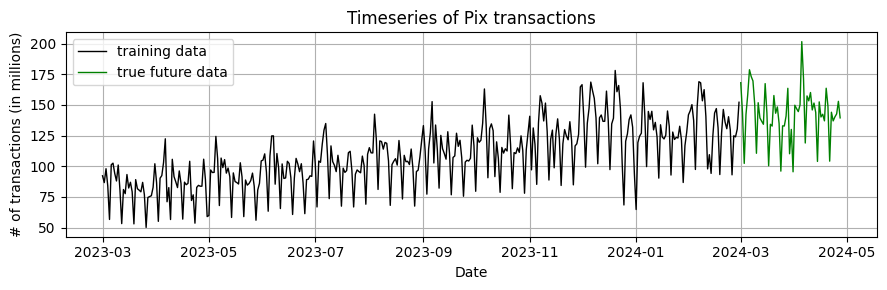

In [169]:
f, ax = plt.subplots(figsize=(9,3))

ax.plot(y_hist.index, y_hist[column], c='k', lw=1, label = 'training data')
ax.plot(y_futr.index, y_futr[column], c='g', lw=1, label = 'true future data')

ax.set_xlabel('Date')
ax.set_ylabel('# of transactions (in millions)')
ax.set_title('Timeseries of Pix transactions')

ax.grid(True)

ax.legend()

plt.tight_layout()
plt.savefig('10.3-dataset.png')
plt.show()

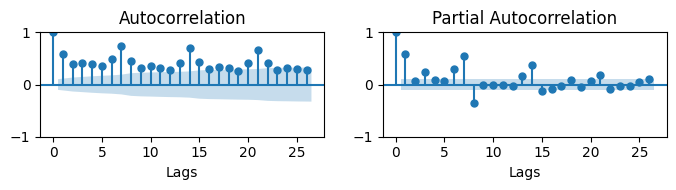

(-1.4783360223945663,
 0.5441996875335904,
 17,
 348,
 {'1%': -3.4492815848836296,
  '5%': -2.8698813715275406,
  '10%': -2.5712138845950587},
 2796.483076952749)

In [191]:
f, axl = plt.subplots(1, 2, figsize=(7,2))
plot_acf(y_hist, ax=axl[0])
plot_pacf(y_hist, ax=axl[1])
axl[0].set_xlabel('Lags')
axl[1].set_xlabel('Lags')

plt.tight_layout()
plt.savefig('10.3-acf_hist.png')
plt.show()

adfuller(y_hist)

ValueError: could not broadcast input array from shape (365,) into shape (371,)

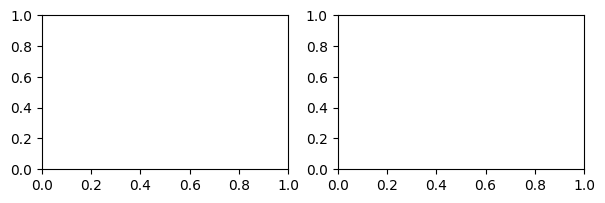

In [192]:
f, axl = plt.subplots(1, 2, figsize=(7,2))
plot_acf(y_diff, ax=axl[0])
plot_pacf(y_diff, ax=axl[1])
axl[0].set_xlabel('Lags')
axl[1].set_xlabel('Lags')

plt.tight_layout()
plt.savefig('10.3-acf_diff.png')
plt.show()

adfuller(y_diff)

In [178]:
SARIMA_model = auto_arima(y_hist, start_p=0, start_q=1,
                         test='adf',
                         max_p=1, max_q=3, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=4, start_Q=4,
                         max_P = 6, max_Q=6, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)
SARIMA_model.summary()

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3086.338, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=2870.521, Time=0.33 sec
 ARIMA(0,1,0)(0,1,3)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,1,4)[7]             : AIC=2873.985, Time=15.75 sec
 ARIMA(0,1,0)(0,1,5)[7]             : AIC=2873.882, Time=16.62 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=2979.101, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=2870.516, Time=0.14 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=2872.455, Time=0.69 sec
 ARIMA(0,1,0)(1,1,3)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(1,1,4)[7]             : AIC=inf, Time=19.06 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=2945.354, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,3)[7]             : AIC=inf, Time=3.71 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  366
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1395.468
Date:                           Wed, 01 May 2024   AIC                           2800.935
Time:                                   03:54:41   BIC                           2820.338
Sample:                               03-01-2023   HQIC                          2808.652
                                    - 02-29-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4763      0.044    -10.845      0.000      -0.562      -0.390
ma.L2         -0.2374      0.066     -3.587      0.000      -0.367      -0.108
ma.S.L7       -1.0010      0.029    -34.142      0.000      -1.058      -0.943
ma.S.L14       0.0674      0.038      1.789      0.074      -0.006       0.141
sigma2       136.1475      5.332     25.535      0.000     125.697     146.598
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1116.62
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [179]:
# errors = {}

def test(p, d, q, P, D, Q, S):
    model = SARIMAX(y_hist, order = (p, d, q), seasonal_order=(P, D, Q, S), freq='1D').fit(disp=False)
    forecast = model.forecast(len(y_futr))
    mse_test = mean_squared_error(forecast, y_futr)

    errors[f'({p},{d},{q})x({P},{D},{Q},{S})'] = mse_test
    print(f'({p},{d},{q})x({P},{D},{Q},{S}): {mse_test:.3f}')

for p in [0, 1]:
    for q in [0, 1]:
        for P in [0, 1]:
            for Q in [0, 1]:
                test(p, 1, q, P, 1, Q, 7)

(0,1,0)x(0,1,0,7): 10436.836
(0,1,0)x(0,1,1,7): 319.293
(0,1,0)x(1,1,0,7): 2129.196
(0,1,0)x(1,1,1,7): 309.492
(0,1,1)x(0,1,0,7): 1189.364
(0,1,1)x(0,1,1,7): 215.573
(0,1,1)x(1,1,0,7): 589.391
(0,1,1)x(1,1,1,7): 225.391
(1,1,0)x(0,1,0,7): 5440.844
(1,1,0)x(0,1,1,7): 219.823
(1,1,0)x(1,1,0,7): 1114.098
(1,1,0)x(1,1,1,7): 210.539
(1,1,1)x(0,1,0,7): 297.981
(1,1,1)x(0,1,1,7): 199.375
(1,1,1)x(1,1,0,7): 265.388
(1,1,1)x(1,1,1,7): 199.512


In [180]:
errors_df = pd.DataFrame(errors.values(), index = errors.keys(), columns = ['rmse'])

errors_df['rmse'] = np.sqrt(errors_df['rmse'])
errors_df.sort_values('rmse')

,rmse
"(0,1,2)x(5,1,5,7)",11.308675
"(1,1,3)x(5,1,5,7)",11.387925
"(0,1,2)x(6,1,6,7)",11.455291
"(0,1,3)x(6,1,6,7)",11.469605
"(1,1,3)x(4,1,5,7)",11.482768
...,...
"(0,1,1)x(0,1,0,7)",34.487156
"(0,0,2)x(3,0,3,7)",36.776484
"(0,1,0)x(1,1,0,7)",46.143211
"(1,1,0)x(0,1,0,7)",73.762075


14.682420567600703


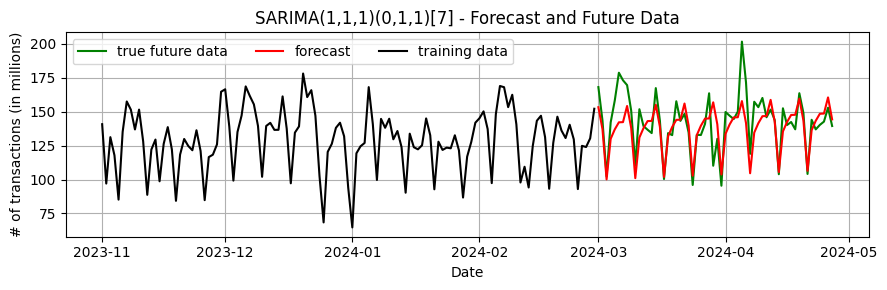

In [187]:
model = SARIMAX(y_hist, order = (0,1,1), seasonal_order=(0, 1, 1, 7), freq='1D').fit(disp=False)
forecast = model.forecast(len(y_futr))
mse_test = mean_squared_error(forecast, y_futr)
print(np.sqrt(mse_test))

plt.figure(figsize=(9,3))
plt.plot(y_futr, c='g', label = 'true future data')
plt.plot(forecast, c='r', label = 'forecast')
plt.plot(y_hist['2023-11-01':], c='k', label = 'training data')

plt.title('SARIMA(1,1,1)(0,1,1)[7] - Forecast and Future Data')

plt.xlabel('Date')
plt.ylabel('# of transactions (in millions)')

plt.legend(ncols=3)

plt.grid()
plt.tight_layout()
plt.savefig('10.3-forecast_simple.png')
plt.show()


/usr/local/python/current/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11.308675037302669


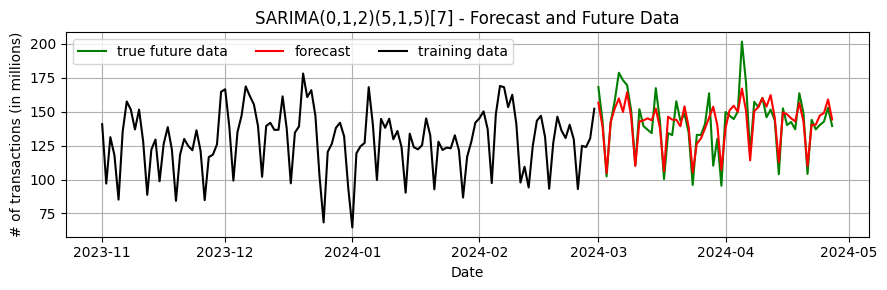

In [188]:
model = SARIMAX(y_hist, order = (0,1,2), seasonal_order=(5, 1, 5, 7), freq='1D').fit(disp=False)
forecast = model.forecast(len(y_futr))
mse_test = mean_squared_error(forecast, y_futr)
print(np.sqrt(mse_test))

plt.figure(figsize=(9,3))
plt.plot(y_futr, c='g', label = 'true future data')
plt.plot(forecast, c='r', label = 'forecast')
plt.plot(y_hist['2023-11-01':], c='k', label = 'training data')

plt.title('SARIMA(0,1,2)(5,1,5)[7] - Forecast and Future Data')

plt.xlabel('Date')
plt.ylabel('# of transactions (in millions)')

plt.legend(ncols=3)

plt.grid()
plt.tight_layout()
plt.savefig('10.3-forecast_complex.png')
plt.show()
